<a href="https://colab.research.google.com/github/Arshad221b/Sign-Language-Recognition/blob/master/sign_language_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
import torch 
import torch.nn as nn 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
from tqdm import tqdm

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import Data

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! kaggle datasets download -d datamunge/sign-language-mnist

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 94% 59.0M/62.6M [00:02<00:00, 41.6MB/s]
100% 62.6M/62.6M [00:02<00:00, 30.0MB/s]


In [8]:
! unzip /content/sign-language-mnist.zip

Archive:  /content/sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [9]:
train = pd.read_csv('/content/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('/content/sign_mnist_test/sign_mnist_test.csv')

In [10]:
train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [11]:
X = train.drop(['label'], axis = 1)
y = train['label']

In [168]:
X.shape, y.shape

((27455, 784), (27455,))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Hyperparameters

In [169]:
BATCH_SIZE = 32
IMAGE_SIZE = 28
NUM_CLASS = y.nunique() + 1

# Preprocessing and Data Loader

In [170]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 30 degrees
    # transforms.RandomResizedCrop(IMAGE_SIZE),  # Randomly crop and resize the image to 224x224
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
])

# Define the fixed transformations
fixed_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define the overall transformation pipeline
transform = transforms.Compose([
    transforms.RandomApply([random_transforms], p=0.5),  # Apply random transformations with a probability of 0.5
    fixed_transforms
])

In [178]:
class SignDataSet(Dataset):
  def __init__(
      self,
      image_df, 
      label_df,
      transform,
      split = None,
  ):
    self.image_df = image_df 
    self.label_df = torch.nn.functional.one_hot(torch.tensor(np.array(label_df))).float()
    self.split = split 
    self.transform = transform

  def __len__(self):
    return len(self.label_df)
  
  def __getitem__(self, index):
    image = self.image_df.iloc[index]
    image = np.reshape(np.array(image), (28,28))

    image = Image.fromarray(image.astype(np.uint8))

    label = self.label_df[index]
    # label = torch.nn.functional.one_hot(torch.tensor(label))

    if self.split == 'train':
      image = self.transform(image)
    return image, label
    
  
  
    

In [179]:

train_data = SignDataSet(X_train, y_train, transform, 'train')
test_data = SignDataSet(X_val, y_val, transform)

In [180]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, drop_last = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, drop_last = True)

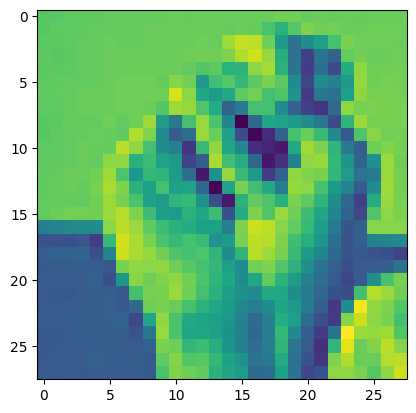

In [181]:
for i, j in train_data: 
  temp_img = i 

  plt.imshow(temp_img.permute(1,2,0))
  break

# Model Building

In [182]:
class SignLabelModel(nn.Module):
    def __init__(self, num_classes):
        super(SignLabelModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
  # Number of classes
model = SignLabelModel(NUM_CLASS).to(device)

In [187]:
num_epochs = 20
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [188]:
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.0658
Epoch [1/20], Loss: 0.2724
Epoch [1/20], Loss: 0.2633
Epoch [1/20], Loss: 0.1275
Epoch [1/20], Loss: 0.1453
Epoch [1/20], Loss: 0.1104


  5%|▌         | 1/20 [00:12<03:50, 12.11s/it]

Epoch [2/20], Loss: 0.1661
Epoch [2/20], Loss: 0.1278
Epoch [2/20], Loss: 0.1764
Epoch [2/20], Loss: 0.2534
Epoch [2/20], Loss: 0.2307
Epoch [2/20], Loss: 0.0386


 10%|█         | 2/20 [00:23<03:34, 11.94s/it]

Epoch [3/20], Loss: 0.0690
Epoch [3/20], Loss: 0.2340
Epoch [3/20], Loss: 0.1753
Epoch [3/20], Loss: 0.0758
Epoch [3/20], Loss: 0.1124
Epoch [3/20], Loss: 0.0213


 15%|█▌        | 3/20 [00:35<03:22, 11.92s/it]

Epoch [4/20], Loss: 0.0999
Epoch [4/20], Loss: 0.3457
Epoch [4/20], Loss: 0.2807
Epoch [4/20], Loss: 0.1919
Epoch [4/20], Loss: 0.1315
Epoch [4/20], Loss: 0.0663


 20%|██        | 4/20 [00:47<03:11, 11.99s/it]

Epoch [5/20], Loss: 0.0740
Epoch [5/20], Loss: 0.0681
Epoch [5/20], Loss: 0.0753
Epoch [5/20], Loss: 0.1335
Epoch [5/20], Loss: 0.0359
Epoch [5/20], Loss: 0.0640


 25%|██▌       | 5/20 [01:00<03:01, 12.08s/it]

Epoch [6/20], Loss: 0.0824
Epoch [6/20], Loss: 0.3208
Epoch [6/20], Loss: 0.1746
Epoch [6/20], Loss: 0.1462
Epoch [6/20], Loss: 0.0325
Epoch [6/20], Loss: 0.0166


 30%|███       | 6/20 [01:12<02:49, 12.11s/it]

Epoch [7/20], Loss: 0.0266
Epoch [7/20], Loss: 0.0698
Epoch [7/20], Loss: 0.1176
Epoch [7/20], Loss: 0.0971
Epoch [7/20], Loss: 0.0727
Epoch [7/20], Loss: 0.0162


 35%|███▌      | 7/20 [01:24<02:36, 12.07s/it]

Epoch [8/20], Loss: 0.1202
Epoch [8/20], Loss: 0.0308
Epoch [8/20], Loss: 0.2305
Epoch [8/20], Loss: 0.0595
Epoch [8/20], Loss: 0.0532
Epoch [8/20], Loss: 0.0617


 40%|████      | 8/20 [01:36<02:24, 12.07s/it]

Epoch [9/20], Loss: 0.0548
Epoch [9/20], Loss: 0.2174
Epoch [9/20], Loss: 0.0857
Epoch [9/20], Loss: 0.0317
Epoch [9/20], Loss: 0.0402
Epoch [9/20], Loss: 0.0114


 45%|████▌     | 9/20 [01:48<02:12, 12.04s/it]

Epoch [10/20], Loss: 0.1095
Epoch [10/20], Loss: 0.0566
Epoch [10/20], Loss: 0.0696
Epoch [10/20], Loss: 0.0521
Epoch [10/20], Loss: 0.0177
Epoch [10/20], Loss: 0.0366


 50%|█████     | 10/20 [02:00<02:00, 12.05s/it]

Epoch [11/20], Loss: 0.1117
Epoch [11/20], Loss: 0.0173
Epoch [11/20], Loss: 0.0519
Epoch [11/20], Loss: 0.0278
Epoch [11/20], Loss: 0.1070
Epoch [11/20], Loss: 0.0231


 55%|█████▌    | 11/20 [02:12<01:48, 12.03s/it]

Epoch [12/20], Loss: 0.0667
Epoch [12/20], Loss: 0.1846
Epoch [12/20], Loss: 0.0576
Epoch [12/20], Loss: 0.0531
Epoch [12/20], Loss: 0.0215
Epoch [12/20], Loss: 0.0326


 60%|██████    | 12/20 [02:24<01:35, 11.98s/it]

Epoch [13/20], Loss: 0.0168
Epoch [13/20], Loss: 0.0464
Epoch [13/20], Loss: 0.0739
Epoch [13/20], Loss: 0.0704
Epoch [13/20], Loss: 0.0531
Epoch [13/20], Loss: 0.0398


 65%|██████▌   | 13/20 [02:36<01:23, 11.95s/it]

Epoch [14/20], Loss: 0.0316
Epoch [14/20], Loss: 0.0414
Epoch [14/20], Loss: 0.0685
Epoch [14/20], Loss: 0.1667
Epoch [14/20], Loss: 0.0165
Epoch [14/20], Loss: 0.0066


 70%|███████   | 14/20 [02:48<01:11, 11.95s/it]

Epoch [15/20], Loss: 0.0273
Epoch [15/20], Loss: 0.0591
Epoch [15/20], Loss: 0.0187
Epoch [15/20], Loss: 0.0399
Epoch [15/20], Loss: 0.0506
Epoch [15/20], Loss: 0.0397


 75%|███████▌  | 15/20 [03:00<00:59, 11.96s/it]

Epoch [16/20], Loss: 0.0701
Epoch [16/20], Loss: 0.0747
Epoch [16/20], Loss: 0.0265
Epoch [16/20], Loss: 0.0180
Epoch [16/20], Loss: 0.0547
Epoch [16/20], Loss: 0.0278


 80%|████████  | 16/20 [03:11<00:47, 11.94s/it]

Epoch [17/20], Loss: 0.0774
Epoch [17/20], Loss: 0.1419
Epoch [17/20], Loss: 0.0338
Epoch [17/20], Loss: 0.0303
Epoch [17/20], Loss: 0.0251
Epoch [17/20], Loss: 0.0426


 85%|████████▌ | 17/20 [03:24<00:35, 11.99s/it]

Epoch [18/20], Loss: 0.1617
Epoch [18/20], Loss: 0.0936
Epoch [18/20], Loss: 0.0481
Epoch [18/20], Loss: 0.0486
Epoch [18/20], Loss: 0.0931
Epoch [18/20], Loss: 0.0111


 90%|█████████ | 18/20 [03:36<00:23, 11.97s/it]

Epoch [19/20], Loss: 0.1165
Epoch [19/20], Loss: 0.1108
Epoch [19/20], Loss: 0.0284
Epoch [19/20], Loss: 0.0708
Epoch [19/20], Loss: 0.0253
Epoch [19/20], Loss: 0.0037


 95%|█████████▌| 19/20 [03:48<00:11, 11.98s/it]

Epoch [20/20], Loss: 0.0214
Epoch [20/20], Loss: 0.0849
Epoch [20/20], Loss: 0.0236
Epoch [20/20], Loss: 0.0095
Epoch [20/20], Loss: 0.0024
Epoch [20/20], Loss: 0.0082


100%|██████████| 20/20 [03:59<00:00, 12.00s/it]

Training finished.
